In [4]:
#initial package installations
#!pip install --upgrade pip
#!pip uninstall -y scipy
!pip install scipy==1.2.3
!pip install --upgrade grpcio==1.24.3 tensorflow==2.0.0
 
!pip install -U h5py sklearn tqdm bleach pillow
!pip install keras-vis
!pip install matplotlib==3.0.3 numpy==1.18.1 seaborn==0.9.0 pandas==0.25.3
!pip install numpy==1.18.1
!pip install scikit-image==0.14.2

  Using cached grpcio-1.24.3-cp35-cp35m-manylinux2010_x86_64.whl (2.2 MB)
Requirement already up-to-date: tensorflow==2.0.0 in /usr/local/envs/py3env/lib/python3.5/site-packages (2.0.0)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.21.1
    Uninstalling grpcio-1.21.1:
      Successfully uninstalled grpcio-1.21.1
Requirement already up-to-date: h5py in /usr/local/envs/py3env/lib/python3.5/site-packages (2.10.0)
Requirement already up-to-date: sklearn in /usr/local/envs/py3env/lib/python3.5/site-packages (0.0)
Requirement already up-to-date: tqdm in /usr/local/envs/py3env/lib/python3.5/site-packages (4.46.0)
Requirement already up-to-date: bleach in /usr/local/envs/py3env/lib/python3.5/site-packages (3.1.5)
Requirement already up-to-date: pillow in /usr/local/envs/py3env/lib/python3.5/site-packages (7.1.2)


  Using cached seaborn-0.9.0-py3-none-any.whl (208 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.7.0
ERROR: Cannot uninstall 'seaborn'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [3]:
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import scipy
print(scipy.__version__)
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
import matplotlib.image as mpimg
import scipy.ndimage as ndimage
import tensorflow as tf

1.2.3


**Vizualizing Saliency Maps**
https://medium.com/@ODSC/visualizing-your-convolutional-neural-network-predictions-with-saliency-maps-9604eb03d766

In [4]:
saved_model = tf.keras.models.load_model('./best_resnetV2101.hdf5')
saved_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Model)          (None, 7, 7, 2048)        42626560  
_________________________________________________________________
flatten_19 (Flatten)         (None, 100352)            0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               25690368  
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 257       
Total params: 68,317,185
Trainable params: 68,219,521
Non-trainable params: 97,664
_________________________________________________________________


In [0]:
img = mpimg.imread('covid_1.jpeg')
plt.imshow(img)

In [0]:
layer_idx = utils.find_layer_idx(saved_model, 'dense_30')
saved_model.layers[-1].activation = activations.linear
saved_model.save('saliency.h5')
model = load_model('saliency.h5')

In [0]:
model = load_model('saliency.h5')
layer_idx = utils.find_layer_idx(model, 'dense_30')

In [0]:
grads = visualize_saliency(model, 
                           layer_idx, 
                           filter_indices=None, 
                           seed_input=img, 
                           backprop_modifier=None,
#                            grad_modifier='absolute',
                           )

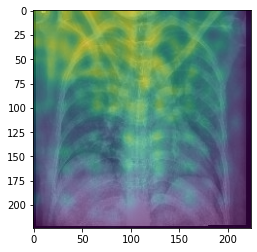

In [0]:
gaus = ndimage.gaussian_filter(grads[:,:,2], sigma=5)
plt.imshow(img)
plt.imshow(gaus, alpha=.6)

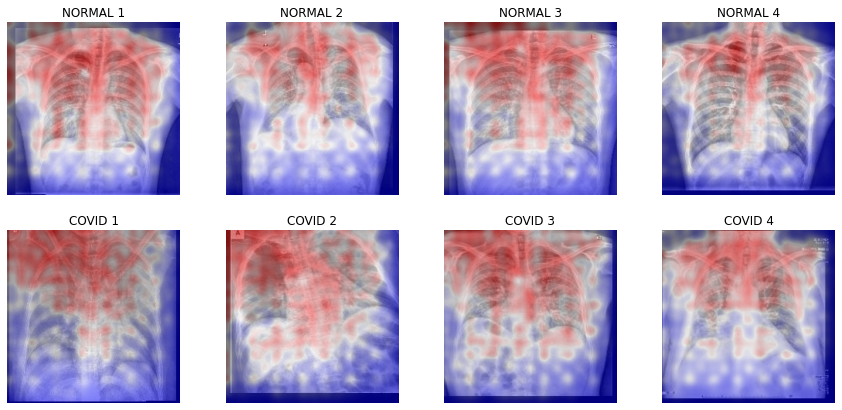

In [0]:
fig, ax = plt.subplots(2, 4, figsize=(15, 7), sharey=True, sharex=True)
[axi.set_axis_off() for axi in ax.ravel()]

for i in range(4):
  normal_img = mpimg.imread('Normal_{}.jpeg'.format(i))
  
  grads = visualize_saliency(model, -1, filter_indices=None, seed_input=normal_img, grad_modifier='absolute', backprop_modifier=None)
  gaus = ndimage.gaussian_filter(grads[:,:,2], sigma=5)
  ax[0, i].imshow(normal_img)
  ax[0, i].imshow(gaus, alpha=.5, cmap="bwr")
  ax[0, i].set_title('NORMAL {}'.format(i+1))

  covid_img = mpimg.imread('covid_{}.jpeg'.format(i))
  grads = visualize_saliency(model, -1, filter_indices=None, seed_input=covid_img, grad_modifier='absolute', backprop_modifier=None)
  gaus = ndimage.gaussian_filter(grads[:,:,2], sigma=5)
  ax[1, i].imshow(covid_img)
  ax[1, i].imshow(gaus, alpha=.5, cmap="bwr")
  ax[1, i].set_title('COVID {}'.format(i+1))


In [5]:
layer_dict = dict([(layer.name, layer) for layer in saved_model.layers])
layer_dict2 = dict([(layer.name, layer) for layer in layer_dict['resnet101v2'].layers])

In [6]:
model = layer_dict['resnet101v2'].summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_27[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

**Vizualizing Convolutional Layers** Using example from Keras Documentation: https://keras.io/examples/conv_filter_visualization/

In [9]:
from __future__ import print_function

import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras import backend as K


def normalize(x):
    """utility function to normalize a tensor.
    # Arguments
        x: An input tensor.
    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.
    # Arguments
        x: A numpy-array representing the generated image.
    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.
    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.
    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.
    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.
        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.
        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calculate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = np.expand_dims(
                process_image(img, input_img_data[0]), 0)

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.
        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        save_img('vgg_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    #assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else len(output_layer.get_weights()[1]))
    assert(filter_lower >= 0
           and filter_upper <= len(output_layer.get_weights()[1])
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, 128):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)

In [ ]:
layer_name = 'conv3_block3_3_conv'
visualize_layer(layer_dict['resnet101v2'], layer_name)

Compute filters 0 to 512
Costs of filter   0:    28 ( 75.24s )
Costs of filter   2:    71 ( 74.54s )
